### TensorFlow的核心组件
分布式TensorFlow的核心组件（core runtime）包括：分发中心（distributed master）、执行器（dataflow executor/worker service）、内核应用（kernel implementation）和最底端的设备层（device layer）/网络层（networking layer）。

分发中心从输入的数据流图中剪取子图（subgraph），将其划分为操作片段并启动执行器。分发中心处理数据流图时会进行预设定的操作优化，包括公共子表达式消去（common subexpression elimination）、常量折叠（constant folding）等。

执行器负责图操作（graph operation）在进程和设备中的运行、收发其它执行器的结果。分布式TensorFlow拥有参数器（parameter server）以汇总和更新其它执行器返回的模型参数。执行器在调度本地设备时会选择进行并行计算和GPU加速。

内核应用负责单一的图操作，包括数学计算、数组操作（array manipulation）、控制流（control flow）和状态管理操作（state management operations）。内核应用使用Eigen执行张量的并行计算、cuDNN库等执行GPU加速、gemmlowp执行低数值精度计算，此外用户可以在内核应用中注册注册额外的内核（fused kernels）以提升基础操作，例如激励函数和其梯度计算的运行效率。

单进程版本的TensorFlow没有分发中心和执行器，而是使用特殊的会话应用（Session implementation）联系本地设备。TensorFlow的C语言API是核心组件和用户代码的分界，其它组件/API均通过C语言API与核心组件进行交互。


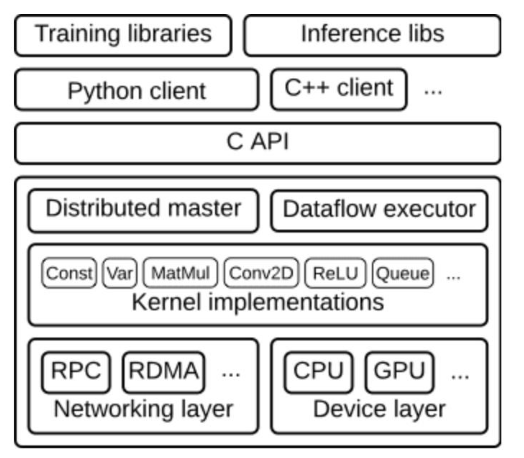


### Tensorflow算法构成(入门)
* 加载一个预构建的数据集。
* 构建对图像进行分类的神经网络机器学习模型。
* 训练此神经网络。
* 评估模型的准确率。


In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

TensorFlow version: 2.5.0


### 加载数据集（MNIST数据集）


In [2]:
mnist = tf.keras.datasets.mnist

# 加载数据（训练集和测试集）
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("输出训练集：",x_train[1][0])

# 将样本数据从整数转换为浮点数
x_train, x_test = x_train / 255.0, x_test / 255.0
print("转化为浮点数：",x_train[0][0])


输出训练集： [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
转化为浮点数： [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


### 构建机器学习模型
通过堆叠层来构建 tf.keras.Sequential 模型。

In [3]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # 展平输入，不影响批量大小。
  tf.keras.layers.Dense(128, activation='relu'), # 全连接层，activation为激活函数。
  tf.keras.layers.Dropout(0.2), # 防止过拟合
  tf.keras.layers.Dense(10)
])


对于每个样本，模型都会返回一个包含 logits 或 log-odds 分数的向量，每个类一个。

In [4]:
predictions = model(x_train[:1]).numpy()
predictions

array([[-0.4733287 , -0.30424675,  0.6715957 ,  0.3059393 , -0.31351   ,
         0.19510423,  0.05493051, -0.22669925,  0.30441767,  0.23633142]],
      dtype=float32)

tf.nn.softmax 函数将这些 logits 转换为每个类的概率：

In [5]:
tf.nn.softmax(predictions).numpy()

array([[0.05612833, 0.06646813, 0.17636664, 0.12235279, 0.06585526,
        0.10951632, 0.09519238, 0.07182769, 0.12216676, 0.11412574]],
      dtype=float32)

【说明】：可以将 tf.nn.softmax 烘焙到网络最后一层的激活函数中。虽然这可以使模型输出更易解释，但不建议使用这种方式，因为在使用 softmax 输出时不可能为所有模型提供精确且数值稳定的损失计算。
使用 losses.SparseCategoricalCrossentropy 为训练定义损失函数，它会接受 logits 向量和 True 索引，并为每个样本返回一个标量损失。

In [6]:
# SparseCategoricalCrossentropy用于计算多分类问题的交叉熵。标签应为一个整数，而不是one-hot编码形式。
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

此损失等于 true 类的负对数概率：如果模型确定类正确，则损失为零。

这个未经训练的模型给出的概率接近随机（每个类为 1/10），因此初始损失应该接近 -tf.math.log(1/10) ~= 2.3。

In [7]:
loss_fn(y_train[:1], predictions).numpy()

2.2116818

在开始训练之前，使用 Keras Model.compile 配置和编译模型。将 optimizer 类设置为 adam，将 loss 设置为您之前定义的 loss_fn 函数，并通过将 metrics 参数设置为 accuracy 来指定要为模型评估的指标。

In [8]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

### 训练并评估模型
使用 Model.fit 方法调整您的模型参数并最小化损失：

In [9]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 2s 824us/step - loss: 0.3036 - accuracy: 0.9118
Epoch 2/5
1875/1875 [==============================] - 2s 812us/step - loss: 0.1486 - accuracy: 0.9563
Epoch 3/5
1875/1875 [==============================] - 2s 844us/step - loss: 0.1116 - accuracy: 0.9660
Epoch 4/5
1875/1875 [==============================] - 2s 874us/step - loss: 0.0914 - accuracy: 0.9717
Epoch 5/5
1875/1875 [==============================] - 2s 825us/step - loss: 0.0769 - accuracy: 0.9762


Model.evaluate 方法通常在 "Validation-set"（验证集） 或 "Test-set" （测试集）上检查模型性能。

In [10]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.0805 - accuracy: 0.9753


[0.080527164041996, 0.9753000140190125]

现在，这个照片分类器的准确度已经达到 98%。

---

## 参考
https://www.tensorflow.org/tutorials/quickstart/beginner?hl=zh-cn